In [11]:
#importing libraries
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
%matplotlib inline

In [2]:
def noise_removable(img):
    #resizing the image
    img = cv.resize(img,(800,600), interpolation=cv.INTER_AREA)
    image_area = img.shape[0] * img.shape[1]

    plt.imshow(img)
    plt.show()
    #converting into grayscale
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    gaussian = cv.GaussianBlur(img_gray, (3,3), 0)
    _, thresh_img = cv.threshold(gaussian, 0, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
    
    kernel_er = np.ones((3,3), np.uint8)
    kernel_di = np.ones((3,3), np.uint8)
    img_erosion = cv.erode(thresh_img, kernel_er, iterations=1) 
    img_dilation = cv.dilate(img_erosion, kernel_di, iterations=1)
    
    #finding the boundary of the all threshold images
    contours, _ = cv.findContours(img_dilation, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)   
    for contour in contours:
        #boundary of each contour
        x,y,w,h = cv.boundingRect(contour)
        #to discard very small noises
        if cv.contourArea(contour) < image_area *0.0005:
            img_dilation[y:(y+h),x:(x+w)] = 0
    
    return img_dilation

In [3]:
def ROI(img):
    row, col = img.shape
    check_rows = row // 15
    
    np_gray = np.array(img, np.uint8)
    one_row = np.zeros((1,col), np.uint8)
    
    #list to append the line by single row 
    images_location = []
    
    #arrya to append rows of single segmented words 
    line_seg_img = np.array([])
    
    for r in range(row-1):
        #checking the black colored row or it's the last row
        if np.equal(img[r:(r+1)], one_row).all() or r == row-2:  
            if len(line_seg_img) != 0:
                if line_seg_img.shape[0] > check_rows:
                    images_location.append(line_seg_img[:-1])
                line_seg_img = np.array([])
            
        else:
            #check if the it's first row of the imaged line
            if line_seg_img.size < 1:
                line_seg_img = np.vstack((np_gray[r], np_gray[r+1]))
            
            else:
                line_seg_img = np.vstack((line_seg_img, np_gray[r+1]))
                           

    return images_location

In [4]:
def dikka_remove(img):
    template = []
    row, col = img.shape
    image_size = row * col
    #fitting the imgage with rows
    img_location = ROI(img)   
    #getting the top rows to remove dikka
    extracted_row = row//4
    without_dikka = img_location[0][extracted_row:row+1,:]
    #to find the width of each character
    contours, _ = cv.findContours(without_dikka, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
#   print(len(contours))
    for contour in contours[::-1]:
        if cv.contourArea(contour) > image_size*0.01:
            x,y,w,h = cv.boundingRect(contour)
            character = ROI(img_location[0][:,x:x+w])  
            template.append(character[0])
        
    return template

In [5]:
def preprocessing(img):
    processed_img = noise_removable(img)
    plt.imshow(processed_img, 'gray')
    plt.show()
    #line segmentation
    line_segmentation = ROI(processed_img)
    #first segmented line display
    plt.imshow(line_segmentation[0], 'gray')
    plt.show()
    
    #word segmentation
    each_word_segmentation = []
    for line in np.asarray(line_segmentation):
        word_segementation = ROI(line.T)
        for words in np.asarray(word_segementation):
            each_word_segmentation.append(words.T)
    #first segmented word display
    plt.imshow(each_word_segmentation[0], 'gray')
    plt.show()
    
    #word transpose for character segmentation
    plt.imshow(each_word_segmentation[0].T, 'gray')
    plt.show()
    
    #dikka
    characters = []
    for word in each_word_segmentation:
        template = dikka_remove(np.array(word))
        characters.append(template)
    #first segmented character display
    plt.imshow(characters[0][0], 'gray')
    plt.show()
        
    return characters

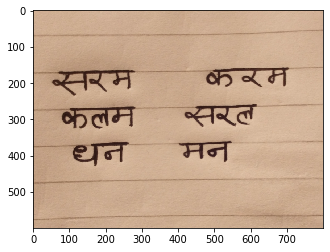

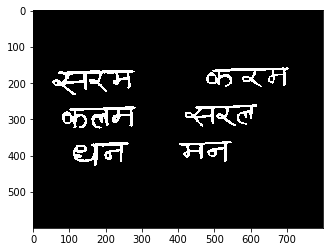

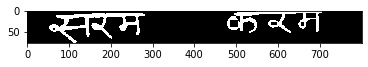

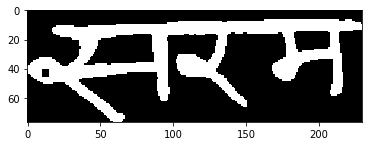

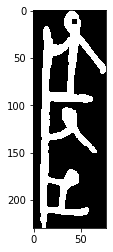

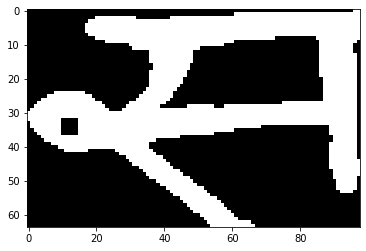

In [6]:
img = cv.imread('OCR_test.jpg')

final_segmented_img = preprocessing(img)

In [7]:
#loading trained model
model = load_model('Handwritten_OCR.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [8]:
def prediction(final_segmented_img):
    words = len(final_segmented_img)
    accuracy = []
    for i in range(words):
        characters = len(final_segmented_img[i])
        for j in range(characters):
            img = final_segmented_img[i][j]
            img = np.pad(img, (2,2)) #padding
            img = cv.resize(img,(32,32), interpolation=cv.INTER_AREA) #resizing the image into same shape as training image shape 
            x = np.asarray(img, dtype = np.float32).reshape(1, 32, 32, 1) / 255  #image normalization
            output = model.predict(x) #prediction probabilities
            output = output.reshape(46)
            predicted = np.argmax(output) #find index of max value
            characters = 'ञ,ट,ठ,ड,ढ,ण,त,थ,द,ध,क,न,प,फ,ब,भ,म,य,र,ल,व,ख,श,ष,स,ह,क्ष,त्र,ज्ञ,ग,घ,ङ,च,छ,ज,झ,०,१,२,३,४,५,६,७,८,९'
            characters = characters.split(',')
            devanagari_label = characters[predicted] #getting value form predicted index
            accuracy.append(output[predicted] * 100) 
            
            print(devanagari_label, end='')
        print(' ', end='')
        
    return np.mean(accuracy)

In [9]:
accuracy = prediction(final_segmented_img)

सरम करम कलम सरल धन मन 

In [10]:
accuracy

99.54403974115849